# Tesla Stock Predictor

This project deals with web scraping Tesla stock prices from the Yahoo Finance page, using Beautiful Soup and Selenium, and using Recurrent Neural Networks (particularly LSTMs) to build a Deep Learning model to predict future stock prices.

In [1]:
import os 
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib
import pandas as pd
from datetime import datetime

In [3]:
df=pd.read_csv('tsla.csv')
df


,Unnamed: 0,Date,Open,High,Low,Close*,Adj Close**,Volume
0,0,"Apr 29, 2020",790.17,803.20,783.16,800.51,800.51,15812100
1,1,"Apr 28, 2020",795.64,805.00,756.69,769.12,769.12,15222000
2,2,"Apr 27, 2020",737.61,799.49,735.00,798.75,798.75,20681400
3,3,"Apr 24, 2020",710.81,730.73,698.18,725.15,725.15,13237600
4,4,"Apr 23, 2020",727.60,734.00,703.13,705.63,705.63,13236700
...,...,...,...,...,...,...,...,...
248,248,"May 06, 2019",250.02,258.35,248.50,255.34,255.34,10833900
249,249,"May 03, 2019",243.86,256.61,243.49,255.03,255.03,23706800
250,250,"May 02, 2019",245.52,247.13,237.72,244.10,244.10,18159300
251,251,"May 01, 2019",238.85,240.00,231.50,234.01,234.01,10704400


Creating a function to plot Time Series Data:

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


There’s a year’s worth of stock prices here, from April 30, 2019 to April 29, 2020, with a few days’ data missing.

But first, there is some Data Cleaning that needs to be done:

The columns “Close” and “Adj Close” have additional * symbols which have to be removed:

In [5]:
df.drop(labels="Unnamed: 0", axis=1, inplace=True)
df.rename(columns={"Close*": "Close", "Adj Close**": "Adj Close"},inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Apr 29, 2020",790.17,803.20,783.16,800.51,800.51,15812100
1,"Apr 28, 2020",795.64,805.00,756.69,769.12,769.12,15222000
2,"Apr 27, 2020",737.61,799.49,735.00,798.75,798.75,20681400
3,"Apr 24, 2020",710.81,730.73,698.18,725.15,725.15,13237600
4,"Apr 23, 2020",727.60,734.00,703.13,705.63,705.63,13236700
...,...,...,...,...,...,...,...
248,"May 06, 2019",250.02,258.35,248.50,255.34,255.34,10833900
249,"May 03, 2019",243.86,256.61,243.49,255.03,255.03,23706800
250,"May 02, 2019",245.52,247.13,237.72,244.10,244.10,18159300
251,"May 01, 2019",238.85,240.00,231.50,234.01,234.01,10704400


Next, it would be much easier if the order of the data was reversed, since the data was originally arranged as latest to earliest.

This would make it easier to use the earlier data for training and the later data for validation/testing.

In [6]:
df=pd.DataFrame(df.values[::-1], df.index, df.columns)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Apr 30, 2019",242.06,244.21,237.0,238.69,238.69,9464600
1,"May 01, 2019",238.85,240.0,231.5,234.01,234.01,10704400
2,"May 02, 2019",245.52,247.13,237.72,244.1,244.1,18159300
3,"May 03, 2019",243.86,256.61,243.49,255.03,255.03,23706800
4,"May 06, 2019",250.02,258.35,248.5,255.34,255.34,10833900
...,...,...,...,...,...,...,...
248,"Apr 23, 2020",727.6,734.0,703.13,705.63,705.63,13236700
249,"Apr 24, 2020",710.81,730.73,698.18,725.15,725.15,13237600
250,"Apr 27, 2020",737.61,799.49,735.0,798.75,798.75,20681400
251,"Apr 28, 2020",795.64,805.0,756.69,769.12,769.12,15222000


Creating a seperate Data Frame to visualize the stock prices better:

In [7]:
adj_close=df['Adj Close']
adj_close.index = df['Date']

adj_close.head()

Date
Apr 30, 2019    238.69
May 01, 2019    234.01
May 02, 2019     244.1
May 03, 2019    255.03
May 06, 2019    255.34
Name: Adj Close, dtype: object

The “Date” column in the original Data Frame is of type “String”, but it has to be of “Datetime” format, to make it easier to plot it in the x-axis.

In [8]:
dates=df['Date']
dates1=[]
for date in dates:
    dates1.append(datetime.strptime(date, '%b %d, %Y'))
dates=pd.core.series.Series(dates1)

Plotting the Adjusted Close Stock Prices over the last year:

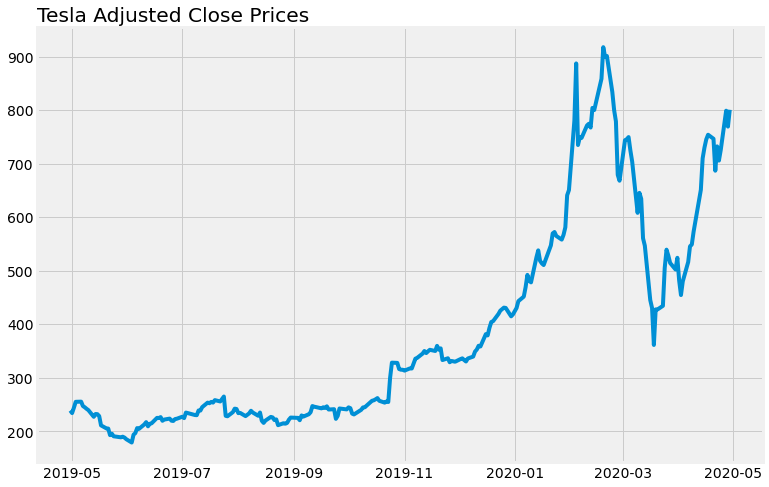

In [9]:
plt.figure(figsize=(13,8))
plt.style.use('fivethirtyeight')
plt.plot(dates1,adj_close)
plt.title("Tesla Adjusted Close Prices",loc='left')
plt.rcParams.update({'font.size': 14})

There’s a huge up-tick in the price sometime after January 2020, which was when Tesla announced strong fourth-quarter financials, which exceeded all expectations.
The dip in the price in March corresponds to the COVID-19 pandemic and the financial crisis that it brought with it.

It does seem to be on the rise now, so it will be interesting to see if the model can predict all these ups and downs.

Creating Series and Time arrays, and converting them to the right type:

In [10]:
series = np.array(adj_close.values)
time = np.array(dates)

In [11]:
series=pd.to_numeric(series,errors='coerce',downcast='float')
series

array([238.69, 234.01, 244.1 , 255.03, 255.34, 247.06, 244.84, 241.98,
       239.52, 227.01, 232.31, 231.95, 228.33, 211.03, 205.36, 205.08,
       192.73, 195.49, 190.63, 188.7 , 189.86, 188.22, 185.16, 178.97,
       193.6 , 196.59, 205.95, 204.5 , 212.88, 217.1 , 209.26, 213.91,
       214.92, 225.03, 224.74, 226.43, 219.62, 221.86, 223.64, 219.76,
       219.27, 222.84, 223.46, 227.17, 224.55, 234.9 , 233.1 , 230.34,
       230.06, 238.92, 238.6 , 245.08, 253.5 , 252.38, 254.86, 253.54,
       258.18, 255.68, 260.17, 264.88, 228.82, 228.04, 235.77, 242.26,
       241.61, 233.85, 234.34, 228.32, 230.75, 233.42, 238.3 , 235.01,
       229.01, 235.  , 219.62, 215.64, 219.94, 226.83, 225.86, 220.83,
       222.15, 211.4 , 215.  , 214.08, 215.59, 221.71, 225.61, 225.01,
       220.68, 229.58, 227.45, 231.79, 235.54, 247.1 , 245.87, 245.2 ,
       242.81, 244.79, 243.49, 246.6 , 240.62, 241.23, 223.21, 228.7 ,
       242.56, 242.13, 240.87, 244.69, 243.13, 233.03, 231.43, 237.72,
      

In [12]:
series.dtype

dtype('float32')

There are about 250 tuples, so a 80-20 split is somewhere around 210 for training set and 40 for testing set. The window size (for creating a windowed_dataset) and batch size can also be specified here.

In [13]:
split_time = 210
adj_train = series[:split_time]
adj_valid = series[split_time:]
dates_train=dates[:split_time]
dates_valid=dates[split_time:]

window_size = 16
batch_size = 32
shuffle_buffer_size = 50

In [14]:
adj_train=pd.to_numeric(adj_train,errors='coerce',downcast='float')
adj_train.astype(np.float)
adj_train

series[...,np.newaxis]

<ipython-input-14-ef1b31e78e99>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj_train.astype(np.float)


array([[238.69],
       [234.01],
       [244.1 ],
       [255.03],
       [255.34],
       [247.06],
       [244.84],
       [241.98],
       [239.52],
       [227.01],
       [232.31],
       [231.95],
       [228.33],
       [211.03],
       [205.36],
       [205.08],
       [192.73],
       [195.49],
       [190.63],
       [188.7 ],
       [189.86],
       [188.22],
       [185.16],
       [178.97],
       [193.6 ],
       [196.59],
       [205.95],
       [204.5 ],
       [212.88],
       [217.1 ],
       [209.26],
       [213.91],
       [214.92],
       [225.03],
       [224.74],
       [226.43],
       [219.62],
       [221.86],
       [223.64],
       [219.76],
       [219.27],
       [222.84],
       [223.46],
       [227.17],
       [224.55],
       [234.9 ],
       [233.1 ],
       [230.34],
       [230.06],
       [238.92],
       [238.6 ],
       [245.08],
       [253.5 ],
       [252.38],
       [254.86],
       [253.54],
       [258.18],
       [255.68],
       [260.17


A function for creating a windowed dataset can be specified here. This is particularly helpful because it helps to create specific sized data slices, to train on them, make predictions, and subsequently learn from those predictions as well.

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

A function for forecasting data, given the series and the model can be specified here:

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


Creating our windowed training set:

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(adj_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(adj_train.shape)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>
(210,)


Specifying the layers of our Keras model.

It has 1 Convolutional Layer, which complements the windowing of the dataset. Simply through extensive trial and error, the configuration of 2 LSTMs (64 and 32 nodes), and 3 Dense Layers (24, 12 and 1 nodes) was selected here.

In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(24, activation="relu"),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

Before actually running our model in its entirity, it might help to specify a learning rate, so the model can be run for a specified number of epochs, and seeing how the model does, a optimized learning rate can be found. This hyperparameter tuning will prove to be very useful later.

In [19]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/Users/kaaneyvaz/miniconda3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1/1 [==============================] - 6s 6s/step - loss: 269.6009 - mae: 270.1009 - lr: 1.0000e-08
Epoch 2/100
1/1 [==============================] - 0s 84ms/step - loss: 269.5738 - mae: 270.0738 - lr: 1.1220e-08
Epoch 3/100
1/1 [==============================] - 0s 61ms/step - loss: 269.5187 - mae: 270.0187 - lr: 1.2589e-08
Epoch 4/100
1/1 [==============================] - 0s 59ms/step - loss: 269.4341 - mae: 269.9341 - lr: 1.4125e-08
Epoch 5/100
1/1 [==============================] - 0s 65ms/step - loss: 269.3179 - mae: 269.8179 - lr: 1.5849e-08
Epoch 6/100
1/1 [==============================] - 0s 64ms/step - loss: 269.1671 - mae: 269.6671 - lr: 1.7783e-08
Epoch 7/100
1/1 [==============================] - 0s 58ms/step - loss: 268.9771 - mae: 269.4771 - lr: 1.9953e-08
Epoch 8/100
1/1 [==============================] - 0s 58ms/step - loss: 268.7423 - mae: 269.2423 - lr: 2.2387e-08
Epoch 9/100
1/1 [==============================] - 0s 57ms/step - loss: 268.4565 - mae: 268.9565 - lr:

Plotting the results of the limited run of the model:

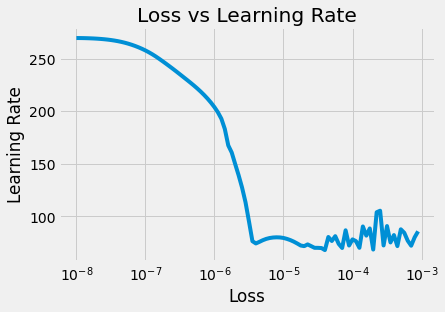

In [22]:
plt.title("Loss vs Learning Rate")
plt.xlabel("Loss")
plt.ylabel("Learning Rate")
plt.semilogx(history.history["lr"], history.history["loss"])

There’s a huge dip in the learning rate somewhere between $10^-7$ and $10^-6$, which helps the gradient descent process in training, helping the model to learn quickly and more effectively, so that can be fixed as the learning rate, and the model is run completely this time:

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 500)
])



optimizer = tf.keras.optimizers.SGD(lr=3e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=350)

Epoch 1/350
1/1 [==============================] - 3s 3s/step - loss: 330.9964 - mae: 331.4964
Epoch 2/350
1/1 [==============================] - 0s 117ms/step - loss: 314.5647 - mae: 315.0647
Epoch 3/350
1/1 [==============================] - 0s 77ms/step - loss: 295.7276 - mae: 296.2276
Epoch 4/350
1/1 [==============================] - 0s 78ms/step - loss: 277.2319 - mae: 277.7319
Epoch 5/350
1/1 [==============================] - 0s 95ms/step - loss: 244.2988 - mae: 244.7988
Epoch 6/350
1/1 [==============================] - 0s 77ms/step - loss: 225.8817 - mae: 226.3817
Epoch 7/350
1/1 [==============================] - 0s 77ms/step - loss: 208.5272 - mae: 209.0272
Epoch 8/350
1/1 [==============================] - 0s 79ms/step - loss: 184.0173 - mae: 184.5173
Epoch 9/350
1/1 [==============================] - 0s 75ms/step - loss: 158.5789 - mae: 159.0789
Epoch 10/350
1/1 [==============================] - 0s 85ms/step - loss: 140.6364 - mae: 141.1363
Epoch 11/350
1/1 [============

The MAE (Mean Absolute Error) seems pretty low after running it for 350 epochs, which is an excellent sign. It started at ~330 and ended around ~19. Now we can build a forecast using the model_forecast function specified earlier:

In [24]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1, 0]

6/6 [==============================] - 1s 75ms/step


There are mainly 2 metrics used for evaluating the accuracy of time series data, Mean Absolute Error and Root Mean Squared Error.

In [25]:
n = tf.keras.metrics.MeanAbsoluteError()
n.update_state(adj_valid, rnn_forecast)
print('Mean Absolute Error: ', n.result().numpy())
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(adj_valid, rnn_forecast)
print('Root Mean Squared Error: ', m.result().numpy())

Mean Absolute Error:  149.89226
Root Mean Squared Error:  169.29364


Considering the fact that there was only 250 data points, and a pretty simple RNN built, a MAE of 150 and RMSE of 171 is extremely good. With more data, and a bigger model, it’s very possible to reduce these numbers.

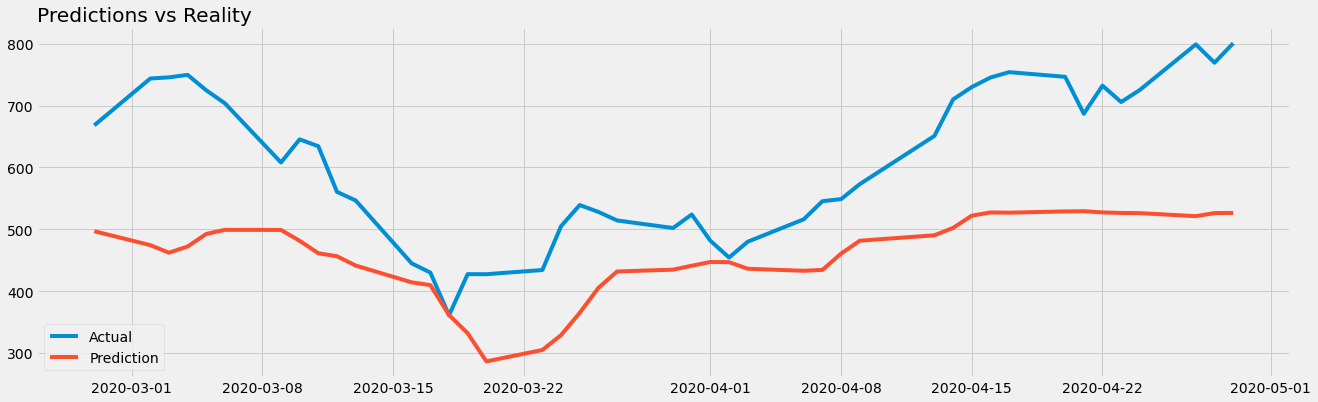

In [26]:
plt.figure(figsize=(20, 6))
plt.style.use('fivethirtyeight')
plt.title("Predictions vs Reality", loc="left")
plt.plot(dates_valid, adj_valid, label="Actual")
plt.plot(dates_valid, rnn_forecast, label= "Prediction")
plt.legend()

The model seemed to have gotten it pretty spot-on. It dips when the actual value dipped and seems to be on the rise, as is the case towards the end.